# Functions

In [1]:
from PIL import Image
import io
from EspPipeML import esp_utilities
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from icecream import ic
from my_operations_ensemble import XDecode
import pandas as pd
from IPython.display import Image as IPImage, display
from matplotlib.path import Path
import matplotlib.patches as patches


def get_pareto_fronts(h, unique=True):
    all_solution = np.empty((0, 5))
    # Processing the data from each generation
    for generation, gen_number in zip(h, range(len(h))):
        F = generation.get('F')
        individual_id_mat = np.arange(F.shape[0])
        gen_number_mat = np.full(F.shape[0], gen_number)

        F = np.hstack((F, individual_id_mat.reshape(-1, 1), gen_number_mat.reshape(-1, 1)))

        all_solution = np.vstack((all_solution, F))
    I = NonDominatedSorting().do(all_solution[:, :3], only_non_dominated_front=True)
    pareto_front = all_solution[I]

    # Remove duplicates
    if unique:
        df_pareto_fronts = pd.DataFrame(pareto_front, columns=['AUC', 'Diversity', 'Effort', 'Individual', 'Generation'])
        df_pareto_fronts = df_pareto_fronts.drop_duplicates(subset=['AUC', 'Diversity', 'Effort'], keep='last')
        pareto_front = df_pareto_fronts.to_numpy()
    return pareto_front

def plot_front_of_front_3d(h, pareto_lines=False, annotate=False, view_angle=0):
    pareto_front = get_pareto_fronts(h)
    
    # Create 3D figure
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')

    for i, pareto_objectives in enumerate(pareto_front):
        ax.scatter(pareto_objectives[1], pareto_objectives[2], pareto_objectives[0], color='blue', facecolors='None', s=80)

        if annotate:
            # Adjust here for position
            offset_x = 0  # Adjust as needed
            offset_y = 0.02  # Adjust as needed
            offset_z = 0  # Adjust as needed, if necessary
            annotation = f"g: {int(pareto_objectives[4])} i: {int(pareto_objectives[3])}"
            ax.text(pareto_objectives[1] + offset_x, pareto_objectives[2] + offset_y, pareto_objectives[0] + offset_z, annotation, color='red', bbox=dict(facecolor='white', alpha=0.5))
    
    

    # Plotar o front de Pareto global
    if pareto_lines:
        sorted_indices = np.lexsort((pareto_front[:, 2], pareto_front[:, 1], pareto_front[:, 0]))
        sorted_global_pareto_points = pareto_front[sorted_indices]
        ax.plot(sorted_global_pareto_points[:, 1], sorted_global_pareto_points[:, 2], sorted_global_pareto_points[:, 0], 'r--', linewidth=1, label='Pareto of Paretos')


    ax.set_xlabel('Diversity')
    ax.set_ylabel('Effort')
    ax.set_zlabel('AUC')
    ax.set_title('The Pareto Fronts Over Generations')
    # ax.legend()
    ax.view_init(elev=20, azim=view_angle)  # Adjust the viewing angle
    ax.grid(True)


    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

def plot_parallel_coordinates(matrix, use_curves=False, highlight=None):
    """
    Plots a parallel coordinates plot for a given numpy matrix with 3 objectives.
    
    Parameters:
        matrix (numpy.ndarray): Input numpy matrix of shape (n, 5).
                                The first 3 columns represent the objectives 1, 2, and 3.
        use_curves (bool): If True, use Bezier curves between points. If False, use straight lines.
        highlight (list of tuples): Optional. List of tuples where each tuple contains (generation, individual).
                                    These will be highlighted in the plot.
    """
    if matrix.shape[1] < 5:
        raise ValueError("Input matrix must have at least 5 columns.")
    
    # Extracting the first three columns (objectives)
    ys = matrix[:, :3]
    ynames = ['Precision', 'Diversity', 'Effort']
    
    # Determine the minimum and maximum values for each objective
    ymins = ys.min(axis=0)
    ymaxs = ys.max(axis=0)
    dys = ymaxs - ymins
    ymins -= dys * 0.05  # add 5% padding below and above
    ymaxs += dys * 0.05
    dys = ymaxs - ymins
    
    # Transform all data to be compatible with the main axis
    zs = np.zeros_like(ys)
    zs[:, 0] = ys[:, 0]
    zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]
    
    fig, host = plt.subplots(figsize=(12, 8))
    
    # Font size for axis labels and ticks
    fontsize = 14
    
    # Create twin axes
    axes = [host] + [host.twinx() for _ in range(ys.shape[1] - 1)]
    for i, ax in enumerate(axes):
        ax.set_ylim(ymins[i], ymaxs[i])
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='y', labelsize=fontsize)  # Set font size for y-axis ticks
        if ax != host:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('right')
            ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))
    
    host.set_xlim(0, ys.shape[1] - 1)
    host.set_xticks(range(ys.shape[1]))
    host.set_xticklabels(ynames, fontsize=fontsize)
    host.tick_params(axis='x', which='major', pad=7)
    host.spines['right'].set_visible(False)
    host.xaxis.tick_top()
    host.set_title('Parallel Coordinates Plot', fontsize=18)
    
    # Determine which lines to highlight
    highlighted_indices = []
    legend_handles = []
    colors = plt.cm.tab10.colors

    if highlight is not None:
        for i, (generation, individual) in enumerate(highlight):
            idx = np.where((matrix[:, 4] == generation) & (matrix[:, 3] == individual))
            highlighted_indices.extend(idx[0])
            if idx[0].size > 0:
                legend_handles.append(patches.Patch(color=colors[i % len(colors)], label=f'Gen {generation}, Ind {individual}'))
    
    for j in range(matrix.shape[0]):
        if highlight is not None and j not in highlighted_indices:
            color = 'lightgray'
            linewidth = 1
            alpha = 0.5
        else:
            color = colors[j % len(colors)]
            linewidth = 2.5 if j in highlighted_indices else 1
            alpha = 1 if j in highlighted_indices else 0.5
        
        if use_curves:
            # Create bezier curves
            verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                             np.repeat(zs[j, :], 3)[1:-1]))
            codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
            path = Path(verts, codes)
            patch = patches.PathPatch(path, facecolor='none', lw=linewidth, edgecolor=color, alpha=alpha)
            host.add_patch(patch)
        else:
            # Plot straight lines between the axes
            host.plot(range(ys.shape[1]), zs[j, :], c=color, lw=linewidth, alpha=alpha)
    
    # Add legend if there are highlighted solutions
    if highlight is not None and legend_handles:
        host.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.15),
                    ncol=len(legend_handles), fontsize=fontsize, frameon=False, markerscale=2)
    
    plt.tight_layout()
    plt.show()





def list_overlap(list1, list2):
    """
    Returns the intersection of two lists.
    
    Parameters:
        list1 (list): The first list.
        list2 (list): The second list.
    
    Returns:
        list: A list containing the elements that are present in both list1 and list2.
    """
    # Convert lists to sets and get the intersection
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    
    # Convert the set back to a list
    return list(intersection)

def get_ensemble_parameters(history, solutions = [(78, 41), (78, 94), (78, 67)], dataloader=None):
    if dataloader is None:
        dataloader = esp_utilities.DatasetLoader('unsw-nb15', scale_data=True, scale_on_full_dataset=False, toy=False)
    feature_names = dataloader.X_train.columns.tolist()

    row = []
    for gen, ind in solutions:
        solution = history[gen].get('X')[ind]
        x_by_classifier = np.split(solution, 5)
        x_decoded = {}

        for xi, clf_name in zip(x_by_classifier, ['dt', 'rf', 'xgb', 'mlp', 'td']):
            x_decoded = XDecode(x=xi, clf_name=clf_name, feature_names=feature_names)
            hp1 = x_decoded.get_first_hp(xi)
            hp2 = x_decoded.get_second_hp(xi)
            features = x_decoded.get_selected_features(feature_names)
            time_features = list_overlap(dataloader.time_based_features, features)
            volume_features = list_overlap(dataloader.volume_based_features, features)

            row.append({
                'gen': gen,
                'ind': ind,
                'model': clf_name,
                'hp1': hp1,
                'hp2': hp2,
                'qt_time_features': len(time_features),
                'qt_volume_features': len(volume_features),
                'ttl_features': len(features)
            }) 
    return pd.DataFrame(row)

esp_utilities.fix_seeds(42)
unsw_nb15 = esp_utilities.DatasetLoader('unsw-nb15', scale_data=True, scale_on_full_dataset=False, toy=False)
qt_figures = {9: 40, 8: 45, 6: 60, 5: 72, 4: 90, 3: 120, 2: 180}
history = esp_utilities.load_from_pickle('../results/nsga2/checkpoint/feature_selection/unsw-nb15_proposal_auc_history.pkl')
pareto_front = get_pareto_fronts(history)
selected_solutions=[(100, 5), (100, 0), (100, 86), (100, 93)] # Average Div, Best Precision, Best Diversity, Best Effort
parameters = get_ensemble_parameters(history, solutions=selected_solutions, dataloader=unsw_nb15)


# images = [plot_front_of_front_3d(history, pareto_lines=False, annotate=True, view_angle=angle) for angle in range(0, 361, int(360/qt_figures[2]))]
# images[0].save('plot_animation.gif', save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)
# i = plot_front_of_front_3d(history, pareto_lines=True, annotate=True, view_angle=0)
# i.save('sua_imagem.png', format='png')


# images = [plot_front_of_front_3d(history, pareto_lines=True, annotate=True, view_angle=angle) for angle in range(0, 361, int(360/qt_figures[2]))]
# images[0].save('plot_animation_lines.gif', save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)


# images = [plot_front_of_front_3d(history, pareto_lines=False, annotate=False, view_angle=angle) for angle in range(0, 361, int(360/qt_figures[2]))]
# images[0].save('plot_animation_no_lines_no_annotate.gif', save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)


# i = plot_front_of_front_3d(history, pareto_lines=False, annotate=True, view_angle=95)
# i.save('overview.png', format='png')


In [2]:
len(pareto_front)

116

# GA Performance Analysis: Dispersion Plots of Pareto

### 3D Dispersion plot

In [3]:
# display(IPImage(url='plot_animation.gif'))
display(IPImage(url='3d_plot_animation_annotate.gif'))

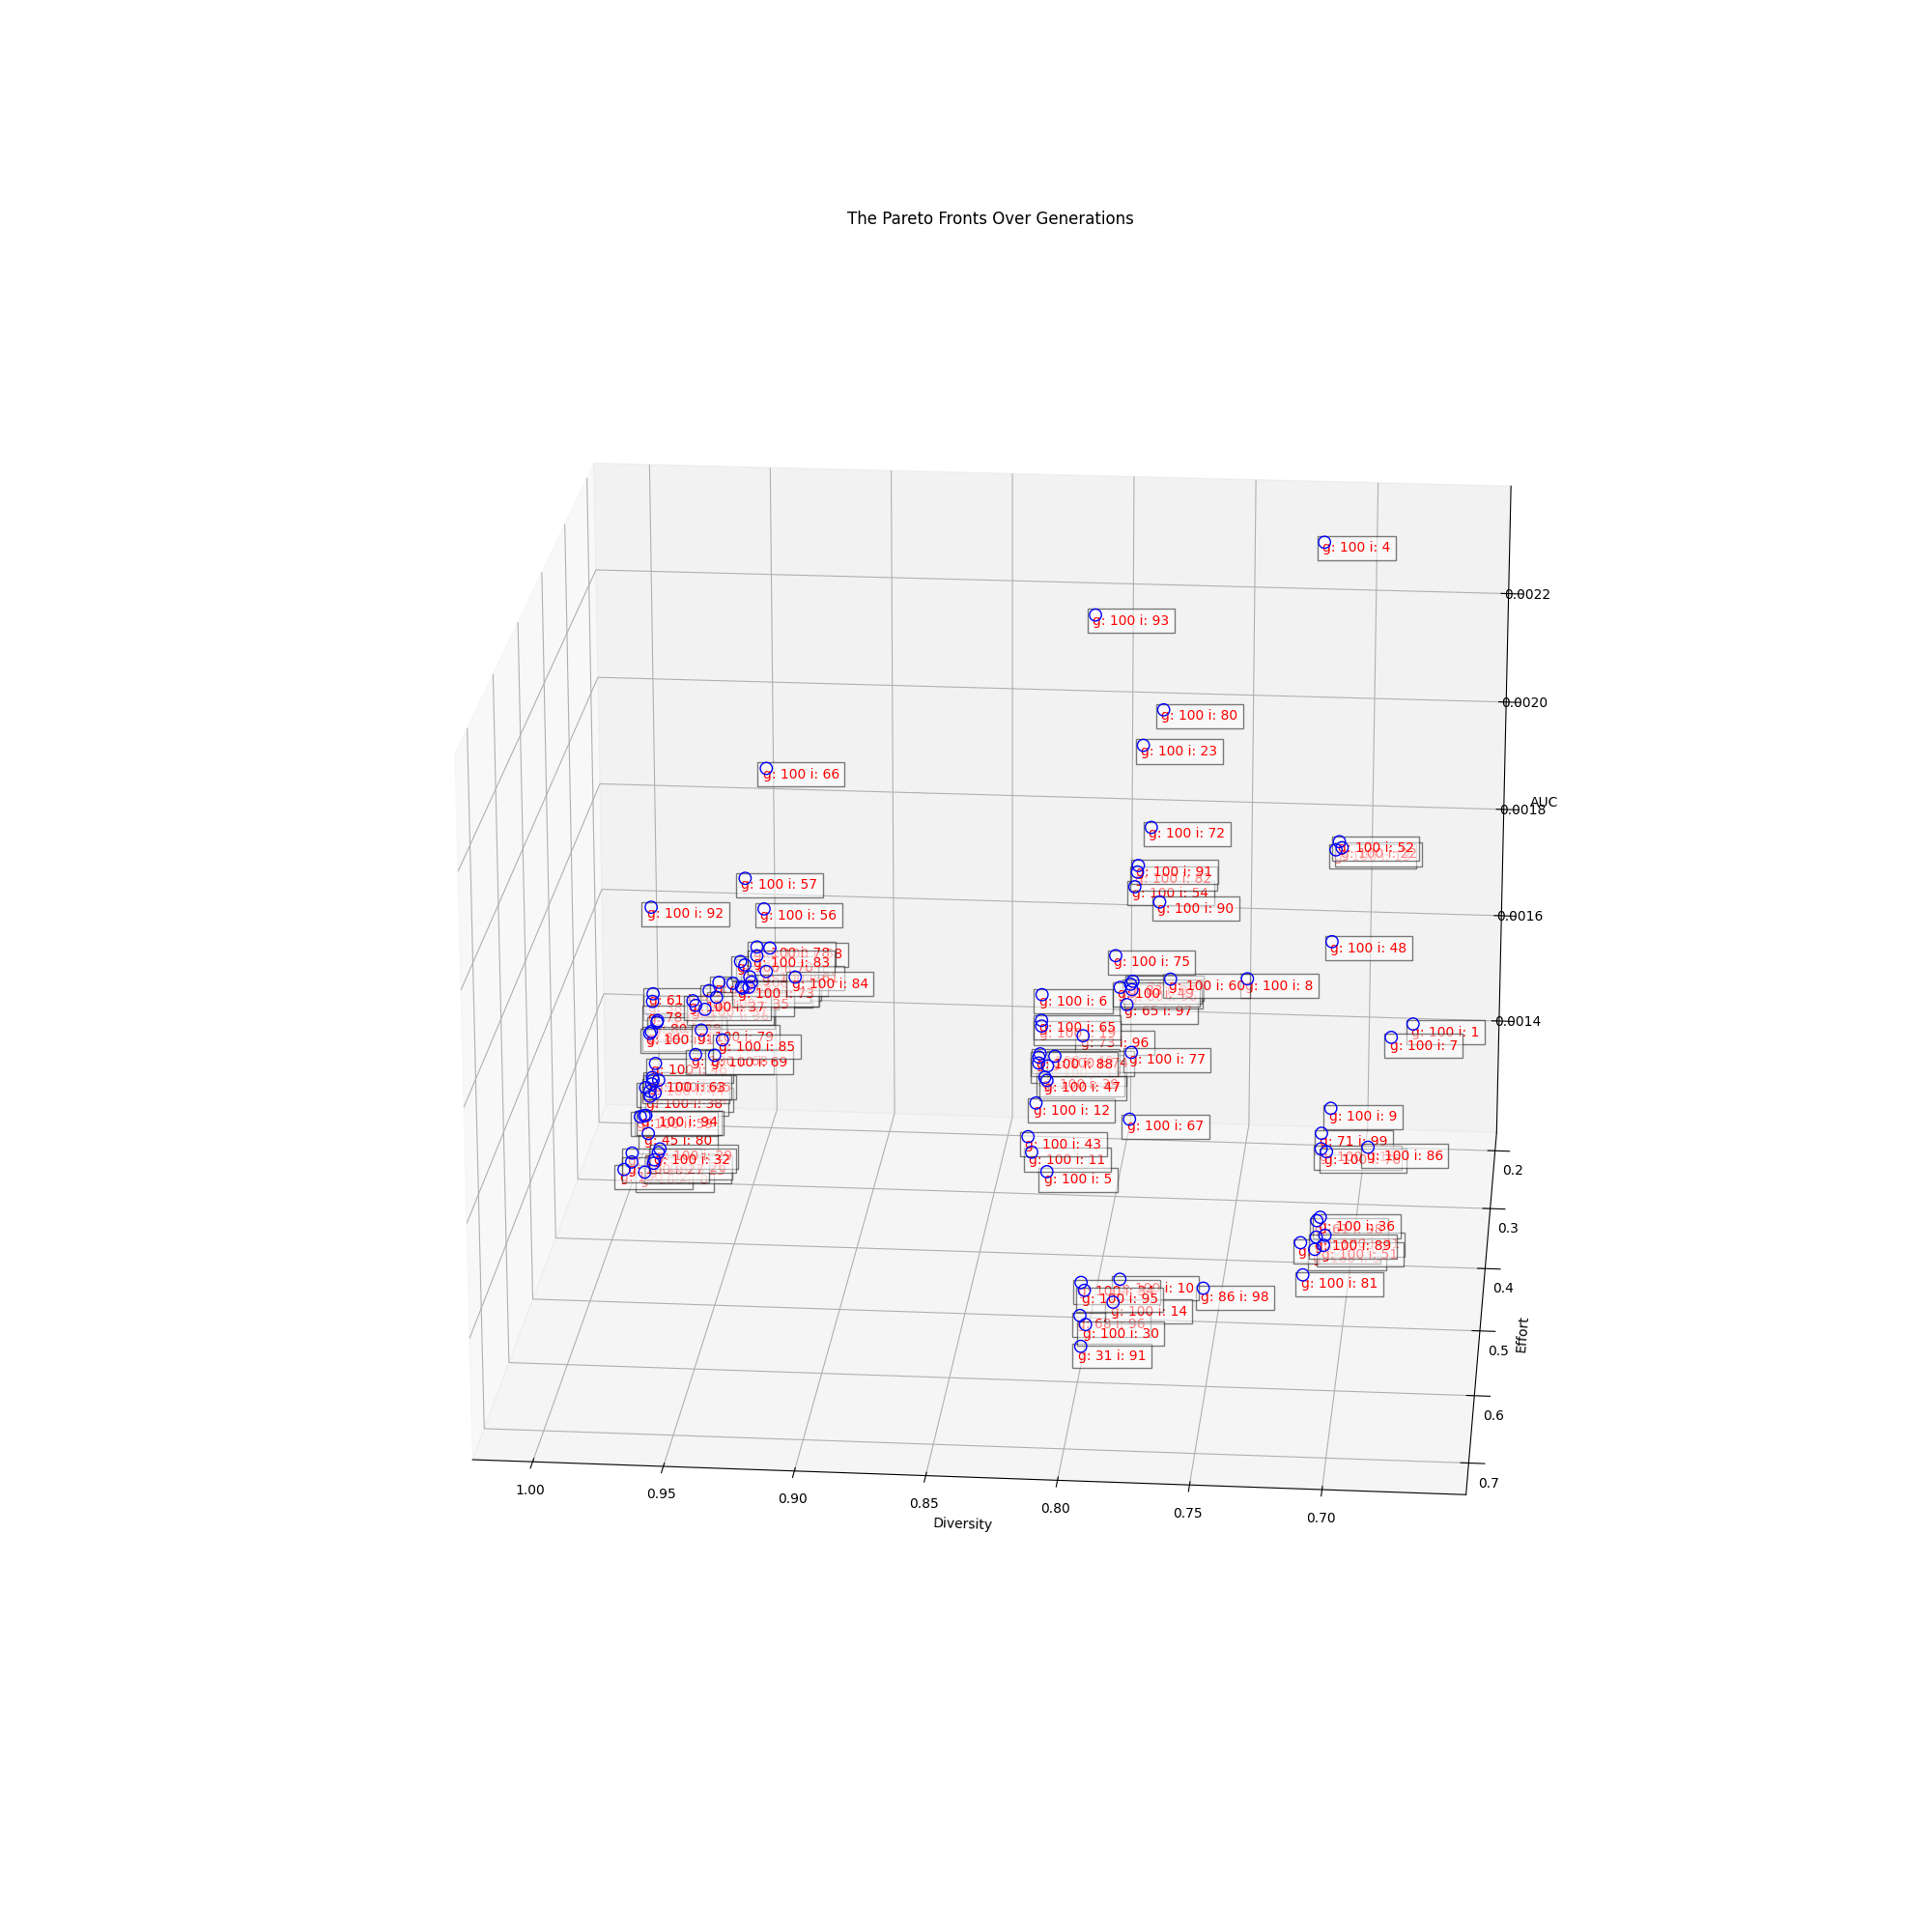

In [4]:
plot_front_of_front_3d(history, pareto_lines=False, annotate=True, view_angle=95)

### 2D dispersion plot

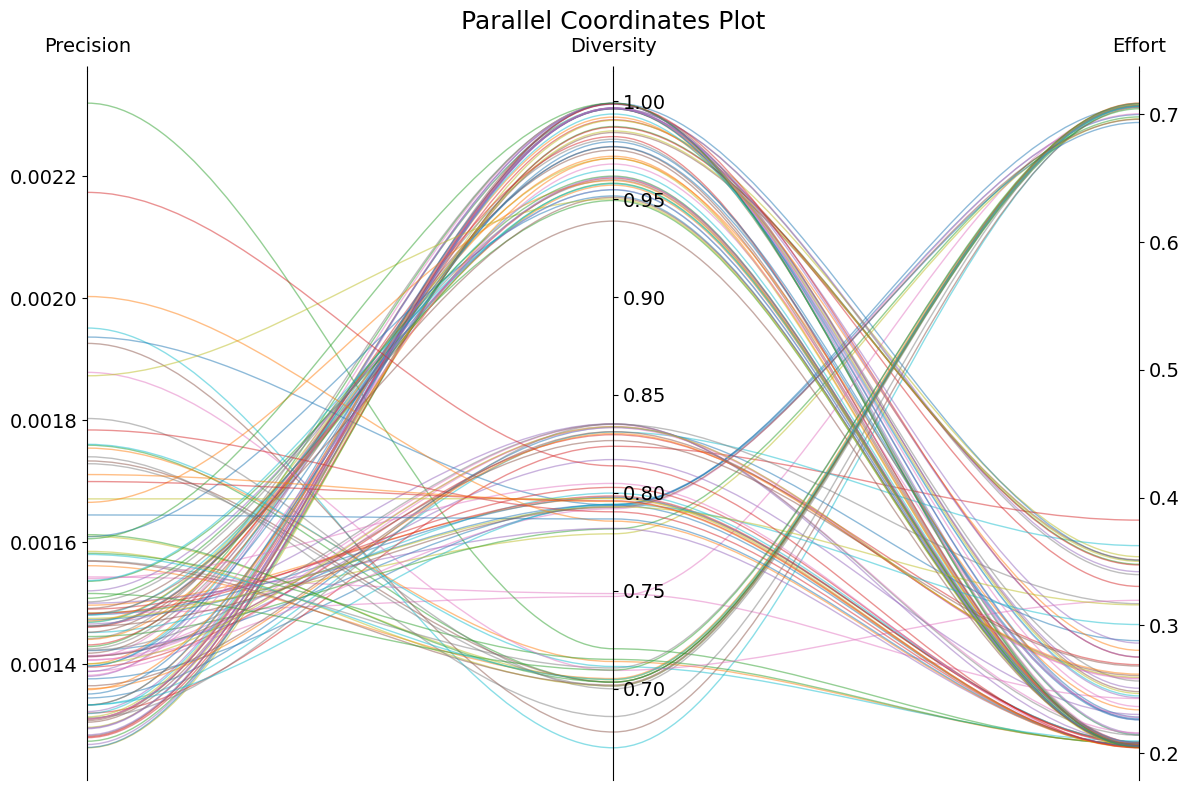

In [5]:
plot_parallel_coordinates(pareto_front, use_curves=True)

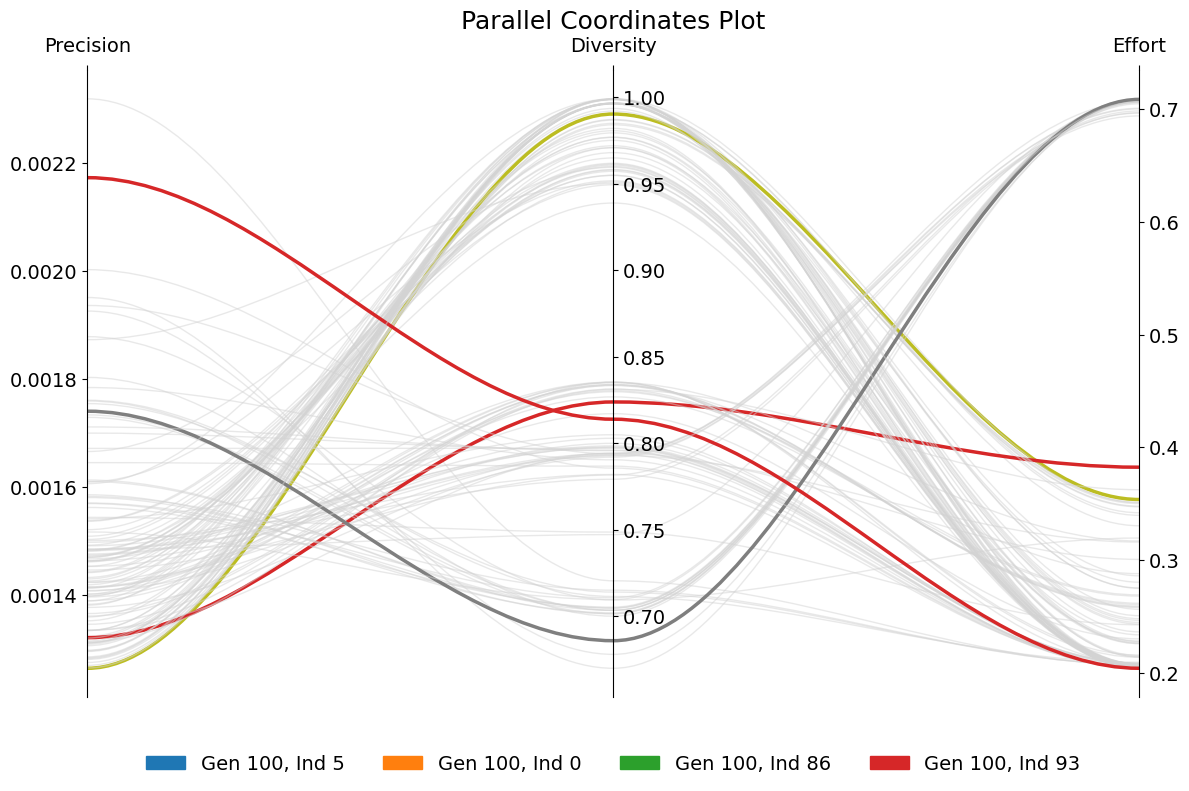

In [6]:
plot_parallel_coordinates(pareto_front, use_curves=True, highlight=selected_solutions)

### Selected Solutions Parameters

In [7]:
parameters

,gen,ind,model,hp1,hp2,qt_time_features,qt_volume_features,ttl_features
0,100,5,dt,5,0,10,9,19
1,100,5,rf,20,93,10,8,18
2,100,5,xgb,18,51,16,15,31
3,100,5,mlp,157,2,12,15,27
4,100,5,td,262,6,9,7,16
5,100,0,dt,5,0,10,9,19
6,100,0,rf,20,93,8,10,18
7,100,0,xgb,18,51,16,15,31
8,100,0,mlp,157,2,14,14,28
9,100,0,td,262,6,8,9,17


# Functions

In [8]:
from my_operations_ensemble import XDecode
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from EspPipeML import esp_utilities
from fastai.tabular.all import *
import copy



def get_ensemble(history, gen, ind, dataloader=None, device='cuda:1'):
    if dataloader is None:
        dataloader = esp_utilities.DatasetLoader('unsw-nb15', scale_data=True, scale_on_full_dataset=False, toy=False)
    feature_names = dataloader.X_train.columns.tolist()
    y_train = dataloader.y_train
    y_test = dataloader.y_test
    y_train_multiclass = dataloader.y_train_multiclass
    y_test_multiclass = dataloader.y_test_multiclass

    solution = history[gen].get('X')[ind]
    x_by_classifier = np.split(solution, 5)
    x_decoded = {}
    X_train_selected = {}
    X_test_selected = {}


    for xi, clf_name in zip(x_by_classifier, ['dt', 'rf', 'xgb', 'mlp', 'td']):
        x_decoded[clf_name] = XDecode(x=xi, clf_name=clf_name, feature_names=feature_names)

        # Get the features for each classifier
        X_train_selected[clf_name] = dataloader.X_train.iloc[:, x_decoded[clf_name].features]
        X_test_selected[clf_name] = dataloader.X_test.iloc[:, x_decoded[clf_name].features]
    
    def train_and_evaluate_sklearn_models(clf, X_train, y_train, X_test):       
        clf.fit(X_train, y_train.values.ravel())
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]
        y_pred_train = clf.predict(X_train)
        y_prob_train = clf.predict_proba(X_train)[:, 1]
        return y_prob, y_pred, y_prob_train, y_pred_train
    
    threshold = 0.3 # threshold for binary classification (mlp and td)

    # Define the classifiers
    clf_dt = DecisionTreeClassifier(
        max_depth=x_decoded['dt'].max_depth,
        random_state=42,
        class_weight='balanced'
    )
    y_prob_dt, y_pred_dt, y_pred_train_dt, y_prob_train_dt = train_and_evaluate_sklearn_models(clf_dt, X_train_selected['dt'], y_train, X_test_selected['dt'])


    clf_rf = RandomForestClassifier(
        n_estimators=x_decoded['rf'].n_estimators,
        max_depth=x_decoded['rf'].max_depth,
        random_state=42,
        class_weight='balanced'
    )
    y_prob_rf, y_pred_rf, y_pred_train_rf, y_prob_train_rf = train_and_evaluate_sklearn_models(clf_rf, X_train_selected['rf'], y_train, X_test_selected['rf'])
    
    count_class_0, count_class_1 = y_train.value_counts()
    scale_pos_weight = count_class_0 / count_class_1

    clf_xgb = XGBClassifier(
        n_estimators=x_decoded['xgb'].n_estimators,
        max_depth=x_decoded['xgb'].max_depth,
        random_state=42, 
        tree_method='hist', 
        # device=device, 
        scale_pos_weight=scale_pos_weight
    )
    y_prob_xgb, y_pred_xgb, y_pred_train_xgb, y_prob_train_xgb = train_and_evaluate_sklearn_models(clf_xgb, X_train_selected['xgb'], y_train, X_test_selected['xgb'])

    torch.cuda.set_device(device)
    layers = [x_decoded['mlp'].n_neurons] * x_decoded['mlp'].n_layers
    # Get the input dimension
    input_dim = X_train_selected['mlp'].shape[1]
    # Create and move the model to the specified device
    clf_mlp = esp_utilities.MLP(
        input_dim=input_dim, 
        num_neurons=x_decoded['mlp'].n_neurons, 
        num_layers=x_decoded['mlp'].n_layers
        )
    clf_mlp.to(device)
    esp_utilities.train_mlp(X_train_selected['mlp'].to_numpy(), y_train.to_numpy(), model=clf_mlp, device=device, y_train_multiclass=y_train_multiclass) # train the model
    y_prob_mlp = esp_utilities.get_probabilities(clf_mlp, X_test_selected['mlp'], device=device).to_numpy() # get the probabilities
    y_pred_mlp = np.array(y_prob_mlp > threshold).astype(int) # get the predictions

    y_prob_train_mlp = esp_utilities.get_probabilities(clf_mlp, X_train_selected['mlp'], device=device).to_numpy() # get the probabilities
    y_pred_train_mlp = np.array(y_prob_train_mlp > threshold).astype(int) # get the predictions


    # Train the classifiers
    td_object = x_decoded['td']
    layers = [td_object.n_neurons] * td_object.n_layers
    y_name = 'label'


    train_df = pd.concat([X_train_selected['td'].reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
    test_df = pd.concat([X_test_selected['td'].reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

    cont_names = x_decoded['td'].selected_feature_names   # Since all features are numerical, I will only have continuous features
    cat_names = []  # No categorical data in your case
    procs = []  # No additional preprocessing needed as the data is already normalized

    splits = esp_utilities.stratified_splitter(train_df, y_train_multiclass, valid_pct=0.2)
    # TabularPandas for training data
    to = TabularPandas(train_df, 
                procs=procs, 
                cat_names=cat_names, 
                cont_names=cont_names, 
                y_names=y_name, 
                splits=splits, 
                y_block=CategoryBlock())  # Use CategoryBlock for classification tasks
    
    # TabularPandas for test data
    to_test = TabularPandas(test_df,
                procs=procs, 
                cat_names=cat_names, 
                cont_names=cont_names, 
                y_names=y_name, 
                y_block=CategoryBlock())
    
    # Create DataLoaders for training and validation
    dls = to.dataloaders(bs=256, device=torch.device(device))

    # Create DataLoaders for test data
    dls_test = to_test.dataloaders(bs=256, device=torch.device(device))

    # Create and move the model to the specified device
    clf_td = tabular_learner(dls, layers=layers)
    clf_td.model.to(torch.device(device))


    # Train the model
    clf_td.fit_one_cycle(100, 0.001, cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0, patience=5)])


    # Get the predictions
    probs_td, targs = clf_td.get_preds(dl=dls_test[0])

    y_prob_td = probs_td[:, 1].numpy()  # Probabilities of class 1, positive class
    y_pred_td = (probs_td[:, 1] > threshold).int().numpy()

    
    # Create DataLoader for full training data
    to_full_train = TabularPandas(train_df,
            procs=procs, 
            cat_names=cat_names, 
            cont_names=cont_names, 
            y_names=y_name, 
            y_block=CategoryBlock())
    dls_full_train = to_full_train.dataloaders(bs=256, device=torch.device(device))
    
    # Get the training predictions on full training data
    probs_train_td, targs_train = clf_td.get_preds(dl=dls_full_train[0])
    y_prob_train_td = probs_train_td[:, 1].numpy()  # Probabilities of class 1, positive class
    y_pred_train_td = (probs_train_td[:, 1] > threshold).int().numpy()


    # Get the mean probabilities
    # mean_probs = np.mean([y_prob_dt, y_prob_rf, y_prob_xgb, y_prob_mlp, y_prob_td], axis=0)
    # # Get the predictions
    # all_preds = np.array([y_pred_dt, y_pred_rf, y_pred_xgb, y_pred_mlp, y_pred_td])
    # # Get the majority voting
    # y_vote = np.sum(all_preds, axis=0) > (all_preds.shape[0] / 2)

    # if fitness_metric == 'auc':
    #     performance_score = 1 - roc_auc_score(y_test, mean_probs)
    # elif fitness_metric == 'f1':
    #     performance_score = 1 - f1_score(y_test, y_vote, average='weighted')

    
    predictions = {
        'dt': y_pred_dt,
        'rf': y_pred_rf,
        'xgb': y_pred_xgb,
        'mlp': y_pred_mlp,
        'td': y_pred_td
    }

    probs = {
        'dt': y_prob_dt,
        'rf': y_prob_rf,
        'xgb': y_prob_xgb,
        'mlp': y_prob_mlp,
        'td': y_prob_td
    }
    
    models = {
        'dt': clf_dt,
        'rf': clf_rf,
        'xgb': clf_xgb,
        'mlp': clf_mlp,
        'td': clf_td
    }

    train_predictions = {
        'dt': y_pred_train_dt,
        'rf': y_pred_train_rf,
        'xgb': y_pred_train_xgb,
        'mlp': y_pred_train_mlp,
        'td': y_pred_train_td
    }

    train_probs = {
        'dt': y_prob_train_dt,
        'rf': y_prob_train_rf,
        'xgb': y_prob_train_xgb,
        'mlp': y_prob_train_mlp,
        'td': y_prob_train_td
    }

    feature_sets = {
    'dt': x_decoded['dt'].selected_feature_names,
    'rf': x_decoded['rf'].selected_feature_names,
    'xgb': x_decoded['xgb'].selected_feature_names,
    'mlp': x_decoded['mlp'].selected_feature_names,
    'td': x_decoded['td'].selected_feature_names,
}

    mean_disagreement = esp_utilities.ensemble_disagreement(predictions)
    mean_disagreement = 1 - mean_disagreement

    
    # effort_score, ensemble_effort = esp_utilities.get_ensemble_effort(clf_dt, clf_rf, clf_xgb, clf_mlp, clf_td)
    df_attackwise_accuracy = esp_utilities.compute_ensemble_attackwise_accuracy(y=y_test, y_multiclass=y_test_multiclass, y_pred_dict=predictions, y_prob_dict=probs)
    # return (performance_score, mean_disagreement, effort_score, y_vote)
    return predictions, train_predictions, probs, train_probs, models, feature_sets, df_attackwise_accuracy

def compare_voting_methods(attack_evaluation_results_df, attack_evaluation_results_dict, predictions, probs, probs_train, dataloader=None):
    if dataloader is None:
        dataloader = esp_utilities.DatasetLoader('unsw-nb15', scale_data=True, scale_on_full_dataset=False, toy=False)
    y_train = dataloader.y_train
    y_test = dataloader.y_test
    y_test_multiclass = dataloader.y_test_multiclass

    base_classifier = attack_evaluation_results_df.loc[attack_evaluation_results_df['model'] != 'ensemble'].reset_index(drop=True)
    compare_results = {}

    #check if there is a key ensemble in the dictionary, if it is drop it

    # check probs for ensemble and drop it
    if 'ensemble' in probs:
        probs.pop('ensemble')

    X_train_meta = pd.DataFrame(probs_train)
    X_test_meta = pd.DataFrame(probs)

    for strategy in ['majority', 'unanimous', 'any', 'w_average', 'max_rule']: #'stacking']:
        ic(strategy)
        # if strategy == 'stacking':
        #     for clf_name in ['dt', 'rf', 'xgb', 'lr']:
        #         # check_consistency(clf_name, probs, probs_train, y_train, y_test)
        #         ic(clf_name)
        #         df_attackwise_accuracy, clf = esp_utilities.compute_ensemble_attackwise_accuracy(y=y_test, y_multiclass=y_test_multiclass, y_pred_dict=predictions, strategy=strategy, clf_name=clf_name, y_prob_dict=probs, y_prob_train_dict=probs_train, y_train=y_train)
                
                

        #         # ensemble_df, final_df = ensemble_attack_evaluation(base_classifier, strategy=strategy, clf_name=clf_name, X_train_meta=X_train_meta, y_train=y_train, X_test_meta=X_test_meta)
        #         ensemble_df, final_df = ensemble_attack_evaluation(base_classifier, strategy=strategy, clf=clf)
        #         attack_evaluation_results_dict = update_dictionary_with_ensemble(ensemble_df, attack_evaluation_results_dict)

        #         compare_results[strategy+'_'+clf_name] = {
        #             'df_attackwise_accuracy': df_attackwise_accuracy,
        #             'attack_evaluation_results_df': final_df,
        #             'attack_evaluation_results_dict': attack_evaluation_results_dict
        #         }
        # else:
        df_attackwise_accuracy = esp_utilities.compute_ensemble_attackwise_accuracy(y=y_test, y_multiclass=y_test_multiclass, y_pred_dict=predictions, strategy=strategy, y_prob_dict=probs)

            
        ensemble_df, final_df = ensemble_attack_evaluation(base_classifier, strategy=strategy)
        attack_evaluation_results_dict = update_dictionary_with_ensemble(ensemble_df, attack_evaluation_results_dict)

        compare_results[strategy] = {
            'df_attackwise_accuracy': df_attackwise_accuracy,
            'attack_evaluation_results_df': final_df,
            'attack_evaluation_results_dict': attack_evaluation_results_dict
        }
    return compare_results

def check_consistency(clf_name, probs, probs_train, y_train, y_test):
    # Verifica a consistência de tamanho
    probs_lengths = [len(v) for v in probs.values()]
    probs_train_lengths = [len(v) for v in probs_train.values()]
    print(f"clf name: {clf_name}")
    print(f"Lengths of probs: {probs_lengths}")
    print(f"Lengths of probs_train: {probs_train_lengths}")
    print(f"Length of y_train: {len(y_train)}")
    print(f"Length of y_test: {len(y_test)}")

    if not all(x == len(y_train) for x in probs_train_lengths):
        raise ValueError("All training probability arrays must be of the same length as y_train")
    if not all(x == len(y_test) for x in probs_lengths):
        raise ValueError("All test probability arrays must be of the same length as y_test")

def ensemble_attack_evaluation(df, strategy='majority', clf=None):
    ensemble_results = []

    # Agrupar o DataFrame por 'attack' e 'factor'
    grouped = df.groupby(['attack', 'factor'])

    for (attack, factor), group in grouped:
        # Extrair todas as predições y_hat para o grupo atual
        all_preds = np.array(group['y_hat'].tolist())

        probs = group[['model', 'y_prob']]

        # Transformar as listas de 'y_prob' em DataFrame
        probs_df = pd.DataFrame(probs['y_prob'].tolist(), index=probs['model'])
        
        # Transpor o DataFrame para que cada coluna seja um classificador
        probs_df = probs_df.transpose()
        
        # Calcular o voto da maioria para as predições
        if clf is None:
            y_vote = esp_utilities.voting_strategy(all_preds, strategy=strategy, test_probs=probs_df)
        else:
            y_vote = clf.predict(probs_df)
            y_vote = y_vote.astype(int)
        
        # Calcular o ASR para o y_vote (precisa do y_true)
        asr = esp_utilities.compute_evasion_rate(np.ones(len(y_vote)), y_vote)
        
        # Adicionar ao DataFrame de resultados do ensemble
        ensemble_results.append({
            'model': 'ensemble',
            'attack': attack,
            'factor': factor,
            'asr': asr,
            'y_hat': y_vote
        })

    # Converter a lista de resultados em um DataFrame
    ensemble_df = pd.DataFrame(ensemble_results)
    final_df = pd.concat([df, ensemble_df], ignore_index=True)
    final_df = final_df.sort_values(by=['attack', 'factor'])
    final_df.reset_index(drop=True, inplace=True)
    return ensemble_df, final_df


def update_dictionary_with_ensemble(ensemble_df, result_dict):
    """
    Updates the dictionary with the results from the ensemble classifier.
    """
    updated_dict = copy.deepcopy(result_dict)
    
    for index, row in ensemble_df.iterrows():
        model = row['model']
        attack = row['attack']
        factor = row['factor']
        asr = row['asr']

        # Create key for 'model' if it doesn't exist
        if model not in updated_dict:
            updated_dict[model] = {}
        
        # Create key for 'attack' if it doesn't exist
        if attack not in updated_dict[model]:
            updated_dict[model][attack] = {}
        
        # Add the ASR value to the dictionary
        updated_dict[model][attack][factor] = asr

    return updated_dict

def evaluate_ensemble(history, gen, ind, dataloader, attack_datasets_dict, device='cuda:0'):
    predictions, train_predictions, probs, train_probs, models, feature_sets, df_attackwise_accuracy = get_ensemble(history=history, gen=gen, ind=ind, dataloader=dataloader, device=device)

    attack_evaluation_results_dict, attack_evaluation_results_df = esp_utilities.attack_evaluation(
        attack_datasets=attack_datasets_dict, 
        nw_attack='DoS', 
        models=models,
        feature_set=dataloader.X_test.columns.to_list(),
        threshold=(0.5, 0.3), 
        feature_set_dict=feature_sets, 
        device=device
        )
    ensemble_df, attack_evaluation_results_df = ensemble_attack_evaluation(attack_evaluation_results_df, strategy='majority')
    attack_evaluation_results_dict = update_dictionary_with_ensemble(ensemble_df, attack_evaluation_results_dict)

    return predictions, train_predictions, probs, train_probs, models, feature_sets, df_attackwise_accuracy, attack_evaluation_results_df, attack_evaluation_results_dict

def get_overview(history, results_voting_methods):
    pareto_front = get_pareto_fronts(history)
    df_pareto_front = pd.DataFrame(pareto_front, columns=['AUC', 'Diversity', 'Effort', 'Individual', 'Generation'])
    df_overview = df_pareto_front.copy()
    df_overview = df_overview.rename(columns={'AUC': 'obj_auc', 'Diversity': 'obj_diversity', 'Effort': 'obj_effort', 'Individual': 'individual', 'Generation': 'generation'})

    for row in df_overview.iterrows():
        gen = row[1]['generation']
        ind = row[1]['individual']

        for strategy in results_voting_methods[gen][ind].keys():
        
            auc = results_voting_methods[gen][ind][strategy]['df_attackwise_accuracy']['ensemble_accuracy'][10] # auc of the ensemble
            normal_accuracy = results_voting_methods[gen][ind][strategy]['df_attackwise_accuracy']['ensemble_accuracy'][0] # accuracy of normal class
            mean_attack_accuracy = results_voting_methods[gen][ind]['majority']['df_attackwise_accuracy'].iloc[1:9]['ensemble_accuracy'].mean() # mean accuracy of attack classes
            df_overview.loc[(df_overview['generation'] == gen) & (df_overview['individual'] == ind), [strategy+'_auc', strategy+'_normal_accuracy', strategy+'_mean_attack_accuracy']] = auc, normal_accuracy, mean_attack_accuracy

            df_aml_results = results_voting_methods[gen][ind][strategy]['attack_evaluation_results_df']
            mean_asr = {'time': 0, 'volume': 0, 'time_volume': 0}
            for (model, attack), group in df_aml_results.groupby(['model', 'attack']):
                if model == 'ensemble':
                    mean_asr[attack] = group['asr'].mean()

            df_overview.loc[(df_overview['generation'] == gen) & (df_overview['individual'] == ind), [strategy+'_time_mean_asr', strategy+'_volume_mean_asr', strategy+'_time_volume_mean_asr']] = mean_asr['time'], mean_asr['volume'], mean_asr['time_volume']
    return df_overview

# from matplotlib.patches import PathPatch
# from matplotlib.path import Path

def adjust_axis_limits(data, padding=0.05):
    """
    Adjusts the axis limits for a given set of data by adding specified padding.
    This function assumes data is 2D and calculates min, max, and range for each column.
    
    Args:
    data (array-like): Numeric data for which to calculate the axis limits.
    padding (float, optional): Percentage of padding to add to each end of the axis. Defaults to 0.05.
    
    Returns:
    tuple: A tuple containing arrays of the adjusted minimums (ymins), maximums (ymaxs), and ranges (dys) of the data.
    """
    data_min = data.min(axis=0)
    data_max = data.max(axis=0)
    # Calculate the range of the data
    dys = data_max - data_min
    epsilon = 1e-8 # Small value to avoid division by zero
    dys = np.where(dys == 0, epsilon, dys) # Replace zeros with epsilon
    # Calculate the new minimum and maximum with padding
    ymins = data_min - dys * padding
    ymaxs = data_max + dys * padding
    dys_adjusted = ymaxs - ymins # Recalculate the range including the padding
    return ymins, ymaxs, dys_adjusted

def plot_parallel_coordinates_overview(matrix, use_curves=False, highlight=None, limits=None, objective_directions=None, axis_names=None, title=None, global_font_size=14, figsize=(15, 8), rotation=0, exclude_first_three_axes=False, save_to_pdf=None, filled=True):
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = global_font_size
    fontsize = global_font_size
    fig, ax = plt.subplots(figsize=figsize)

    ys = matrix.drop(columns=['individual', 'generation']).to_numpy()
    ynames = matrix.drop(columns=['individual', 'generation']).columns

    if limits is None:
        ymins, ymaxs, dys = adjust_axis_limits(ys)
    else:
        ymins, ymaxs, dys = limits

    if exclude_first_three_axes:
        if objective_directions:
            objective_directions = objective_directions[3:]
        ys = ys[:, 3:]
        ynames = ynames[3:]
        ymins = ymins[3:]
        ymaxs = ymaxs[3:]
        dys = dys[3:]

    zs = np.zeros_like(ys)
    zs[:, 0] = ys[:, 0]
    zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]

    axes = [ax] + [ax.twinx() for _ in range(ys.shape[1] - 1)]
    for i, axis in enumerate(axes):
        axis.set_ylim(ymins[i], ymaxs[i])
        axis.spines['top'].set_visible(False)
        axis.spines['bottom'].set_visible(False)
        axis.tick_params(axis='y', labelsize=fontsize)
        if axis != ax:
            axis.spines['left'].set_visible(False)
            axis.yaxis.set_ticks_position('right')
            axis.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

    ax.set_xlim(0, ys.shape[1] - 1)
    ax.set_xticks(range(ys.shape[1]))

    if axis_names:
        if exclude_first_three_axes:
            axis_names = axis_names[3:]
        if objective_directions:
            updated_labels = [f'{name} {"↑" if dir == 1 else "↓"}' for name, dir in zip(axis_names, objective_directions)]
            ax.set_xticklabels(updated_labels, fontsize=fontsize, rotation=rotation, ha='right')
        else:
            ax.set_xticklabels(axis_names, fontsize=fontsize, rotation=rotation, ha='right')
    else:
        if objective_directions:
            updated_labels = [f'{name} {"↑" if dir == 1 else "↓"}' for name, dir in zip(ynames, objective_directions)]
            ax.set_xticklabels(updated_labels, fontsize=fontsize, rotation=rotation, ha='right')

    ax.tick_params(axis='x', which='major', pad=7)
    ax.spines['right'].set_visible(False)
    ax.xaxis.tick_top()
    if title:
        ax.set_title(title, fontsize=18)

    highlighted_indices = []
    legend_handles = []

    # Custom color order: move red to the first position
    custom_colors = ['#d62728'] + list(plt.cm.tab10.colors[:3]) + list(plt.cm.tab10.colors[4:])

    # Define the marker types to be used
    markers = ['*', 'o', 's', 'D', 'P', 'X', 'p', '^', 'v', '<', '>']  # At least 10 markers
    marker_size = 100  # Uniform marker size for non-stars
    star_marker_size = 200  # Larger size for stars to make them appear visually similar

    color_map = {}

    # First, plot the grey lines (non-highlighted) with a lower zorder
    for j in range(matrix.shape[0]):
        if highlight is None or (matrix.iloc[j]['generation'], matrix.iloc[j]['individual']) not in highlight:
            line_data = zs[j, :]
            ax.plot(range(ys.shape[1]), line_data, c='lightgray', lw=1, alpha=0.4, zorder=1)  # Lower zorder for background

    # Now, plot the highlighted lines (except the first one) with markers with a higher zorder
    legend_name = ['Average', 'Precision', 'Diversity', 'Effort']

    if highlight is not None:
        for i, ((generation, individual), l) in enumerate(zip(highlight, legend_name)):
            idx = matrix[(matrix['generation'] == generation) & (matrix['individual'] == individual)].index
            highlighted_indices.extend(idx)
            if idx.size > 0:
                if i == 0:
                    # Skip plotting the first highlight (star) for now
                    continue
                else:
                    # For other highlights
                    color = custom_colors[i % len(custom_colors)]
                    marker = markers[i % len(markers)]
                    size = marker_size  # Use uniform size for other markers
                    line_width = 1.5  # Thinner line for the other highlights
                    line_opacity = 0.7  # Make the line more transparent

                color_map[(generation, individual)] = color
                # Add the handle for the legend
                legend_handles.append(Line2D([0], [0], marker=marker, color='w', markerfacecolor=color, markersize=8, label=l))

                for j in idx:
                    line_data = zs[j, :]
                    ax.plot(range(ys.shape[1]), line_data, c=color, lw=line_width, alpha=line_opacity, zorder=3, linestyle='--')

                    # Plot markers with or without fill
                    face_color = color if filled else 'none'
                    ax.scatter(range(ys.shape[1]), line_data, edgecolors=[color]*ys.shape[1], facecolors=face_color, marker=marker, s=size, zorder=4)

        # Plot the star (first highlight) last to avoid overlap
        idx_star = matrix[(matrix['generation'] == highlight[0][0]) & (matrix['individual'] == highlight[0][1])].index
        color_star = custom_colors[0]  # Red as the first color
        legend_handles.append(Line2D([0], [0], marker='*', color='w', markerfacecolor=color_star, markersize=12, label=legend_name[0]))

        for j in idx_star:
            line_data = zs[j, :]
            ax.plot(range(ys.shape[1]), line_data, c=color_star, lw=2.5, alpha=1, zorder=5, linestyle='--')
            ax.scatter(range(ys.shape[1]), line_data, edgecolors=[color_star]*ys.shape[1], facecolors='none' if not filled else color_star, marker='*', s=star_marker_size, zorder=6)

    if highlight is not None and legend_handles:
        ax.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=len(legend_handles), fontsize=fontsize, frameon=False, markerscale=1.5)

    plt.tight_layout()

    if save_to_pdf:
        path = '../results/nsga2/feature_selection/proposal/best_solutions_parallel_coordinates_'
        plt.savefig(path+save_to_pdf, format='pdf')

    plt.show()

In [9]:
attack_datasets = esp_utilities.load_realistic_attacks(data_loader=unsw_nb15)

pareto_front = get_pareto_fronts(history)
df_pareto_front = pd.DataFrame(pareto_front, columns=['AUC', 'Diversity', 'Effort', 'Individual', 'Generation'])


device = 'cuda:0'
results = {}


index = 0
for (generation, individual), group in df_pareto_front.groupby(['Generation', 'Individual']):
    print(f"Generation: {generation}, Individual: {individual} index: {index}")
    index+=1

    #check dictionary key
    if generation not in results:
        results[generation] = {}

    predictions, train_predictions, probs, train_probs, models, feature_sets, df_attackwise_accuracy, attack_evaluation_results_df, attack_evaluation_results_dict = evaluate_ensemble(history, int(generation), int(individual), dataloader=unsw_nb15, attack_datasets_dict=attack_datasets, device=device)
    results[generation][individual] = {
        'predictions': predictions,
        'train_predictions': train_predictions,
        'probs': probs,
        'train_probs': train_probs,
        'models': models,
        'feature_sets': feature_sets,
        'df_attackwise_accuracy': df_attackwise_accuracy,
        'attack_evaluation_results_df': attack_evaluation_results_df,
        'attack_evaluation_results_dict': attack_evaluation_results_dict
    } # 2864 minutes and 11 sec
    esp_utilities.save_to_pickle(results, 'proposal_plots/results_pareto_front.pkl') 
# results = esp_utilities.load_from_pickle('proposal_plots/results_pareto_front.pkl')

In [10]:
results_voting_methods = {}
for pop in results.keys():
    for ind in results[pop].keys():
        #check if results_volting_methods pop key exists
        if pop not in results_voting_methods:
            results_voting_methods[pop] = {}

        ic(pop, ind)
        results_voting_methods[pop][ind] = compare_voting_methods(
            attack_evaluation_results_df=results[pop][ind]['attack_evaluation_results_df'], 
            attack_evaluation_results_dict=results[pop][ind]['attack_evaluation_results_dict'], 
            predictions=results[pop][ind]['predictions'], 
            probs=results[pop][ind]['probs'],
            probs_train=results[pop][ind]['train_probs'], 
            dataloader=unsw_nb15
            )
        # results[pop][ind]['compare_results'] = compare_results
    esp_utilities.save_to_pickle(results_voting_methods, 'proposal_plots/results_voting_methods_pareto_front.pkl') 
# results_voting_methods = esp_utilities.load_from_pickle('proposal_plots/results_voting_methods_pareto_front.pkl')

# Results

In [11]:
pd.set_option('display.max_rows', None)  # Set to None to display all rows
pd.set_option('display.max_columns', None)  # Set to None to display all columns

# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

# Set the range of each group of features
ga_inf = list(range(0, 5))  # Columns 0 to 4
majority = list(range(5, 11))  # Columns 5 to 10
unanimous = list(range(11, 17))  # Columns 11 to 16
any = list(range(17, 23))  # Columns 17 to 22
w_average = list(range(23, 29))  # Columns 23 to 28
max_rule = list(range(29, 35))  # Columns 29 to 34


# Get the overview DataFrame with the results of GA and the voting methods
# df_overview = get_overview(history, results_voting_methods)
df_overview = pd.read_csv('proposal_plots/df_overview.csv')

# Adjust the sorting criteria as needed and max number of solutions to display
df = df_overview.sort_values(by=['obj_diversity', 'obj_auc'], ascending=True).iloc[:10, :]

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)

# Create a matrix with the selected solutions
matrix = np.concatenate((df.iloc[:, ga_inf+majority].to_numpy(), df.iloc[:, ga_inf+unanimous].to_numpy(), df.iloc[:, ga_inf+any].to_numpy(), df.iloc[:, ga_inf+w_average].to_numpy(), df.iloc[:, ga_inf+max_rule].to_numpy()), axis=0)

# drop columns 3 and 4 of matrix (individual and generation)
matrix = np.delete(matrix, [3, 4], axis=1)

# Get the axis limits for each column of the matrix. The limits will be used to adjust the plot axes scales.
limits = adjust_axis_limits(matrix, 0.05)

# Define the directions of the objectives. 1 means higher is better, -1 means lower is better.
objective_directions = [-1, -1, -1, 1, 1, 1, -1, -1, -1]

In [12]:
df_overview.sort_values(by=['obj_diversity', 'obj_auc'], ascending=True).iloc[:10, :]

,obj_auc,obj_diversity,obj_effort,individual,generation,majority_auc,majority_normal_accuracy,majority_mean_attack_accuracy,majority_time_mean_asr,majority_volume_mean_asr,majority_time_volume_mean_asr,unanimous_auc,unanimous_normal_accuracy,unanimous_mean_attack_accuracy,unanimous_time_mean_asr,unanimous_volume_mean_asr,unanimous_time_volume_mean_asr,any_auc,any_normal_accuracy,any_mean_attack_accuracy,any_time_mean_asr,any_volume_mean_asr,any_time_volume_mean_asr,w_average_auc,w_average_normal_accuracy,w_average_mean_attack_accuracy,w_average_time_mean_asr,w_average_volume_mean_asr,w_average_time_volume_mean_asr,max_rule_auc,max_rule_normal_accuracy,max_rule_mean_attack_accuracy,max_rule_time_mean_asr,max_rule_volume_mean_asr,max_rule_time_volume_mean_asr
29,0.001951,0.669781,0.706673,1.0,100.0,0.986590,0.956541,0.993004,0.003889,0.350715,0.388110,0.986590,0.990191,0.993004,0.548369,0.802778,0.887996,0.986590,0.448807,0.993004,0.000101,0.012511,0.004737,0.986590,1.0,0.993004,1.0,1.0,1.0,0.986590,0.999837,0.993004,0.974428,0.991161,0.991539
35,0.001926,0.677828,0.705398,7.0,100.0,0.987042,0.955900,0.998254,0.003038,0.357754,0.408418,0.987042,0.990292,0.998254,0.561667,0.809645,0.891114,0.987042,0.455050,0.998254,0.000111,0.011981,0.004572,0.987042,1.0,0.998254,1.0,1.0,1.0,0.987042,0.999937,0.998254,0.984971,0.993020,0.993153
107,0.001740,0.685734,0.708361,86.0,100.0,0.987935,0.955469,0.998020,0.005125,0.422158,0.488841,0.987935,0.990035,0.998020,0.552177,0.841842,0.921709,0.987935,0.845002,0.998020,0.000122,0.028976,0.021802,0.987935,1.0,0.998020,1.0,1.0,1.0,0.987935,0.999898,0.998020,0.993782,0.995492,0.995726
37,0.001803,0.699913,0.706455,9.0,100.0,0.987877,0.956100,0.997535,0.005104,0.435892,0.503827,0.987877,0.990685,0.997535,0.566700,0.850262,0.935132,0.987877,0.846956,0.997535,0.000111,0.030015,0.026749,0.987877,1.0,0.997535,1.0,1.0,1.0,0.987877,0.999814,0.997535,0.965323,0.993073,0.992411
97,0.001729,0.701276,0.707104,76.0,100.0,0.987480,0.955737,0.998581,0.003909,0.425072,0.481763,0.987480,0.989466,0.998581,0.540055,0.817940,0.904202,0.987480,0.448861,0.998581,0.000101,0.012503,0.008612,0.987480,1.0,0.998581,1.0,1.0,1.0,0.987480,0.999641,0.998581,0.993508,0.997330,0.997196
48,0.001585,0.701372,0.707584,21.0,100.0,0.988067,0.955977,0.997965,0.006188,0.439966,0.519696,0.988067,0.991557,0.997965,0.601266,0.877746,0.950460,0.988067,0.448350,0.997965,0.000122,0.011252,0.005973,0.988067,1.0,0.997965,1.0,1.0,1.0,0.988067,0.999949,0.997965,0.993599,0.995477,0.995095
75,0.001569,0.701838,0.708729,51.0,100.0,0.988316,0.955772,0.998760,0.004122,0.396778,0.458184,0.988316,0.990361,0.998760,0.574043,0.809877,0.892404,0.988316,0.448160,0.998760,0.000111,0.012188,0.004150,0.988316,1.0,0.998760,1.0,1.0,1.0,0.988316,0.999911,0.998760,0.982327,0.990416,0.990548
12,0.001759,0.703275,0.706034,99.0,71.0,0.987807,0.955567,0.998366,0.004831,0.426301,0.478668,0.987807,0.989915,0.998366,0.553980,0.852720,0.928651,0.987807,0.450208,0.998366,0.000101,0.012693,0.005932,0.987807,1.0,0.998366,1.0,1.0,1.0,0.987807,0.999929,0.998366,0.989569,0.993736,0.993982
45,0.001733,0.703304,0.706833,18.0,100.0,0.988049,0.955912,0.998306,0.002724,0.369623,0.405198,0.988049,0.990479,0.998306,0.580960,0.838622,0.922054,0.988049,0.448138,0.998306,0.000041,0.012272,0.004198,0.988049,1.0,0.998306,1.0,1.0,1.0,0.988049,0.999960,0.998306,0.990683,0.993084,0.993698
62,0.001613,0.703335,0.704435,36.0,100.0,0.987905,0.955113,0.998559,0.003271,0.408399,0.464024,0.987905,0.989710,0.998559,0.544106,0.841713,0.921799,0.987905,0.448541,0.998559,0.000101,0.012735,0.005578,0.987905,1.0,0.998559,1.0,1.0,1.0,0.987905,0.999909,0.998559,0.997245,0.998876,0.998835


### Parallel Plot Coodinates

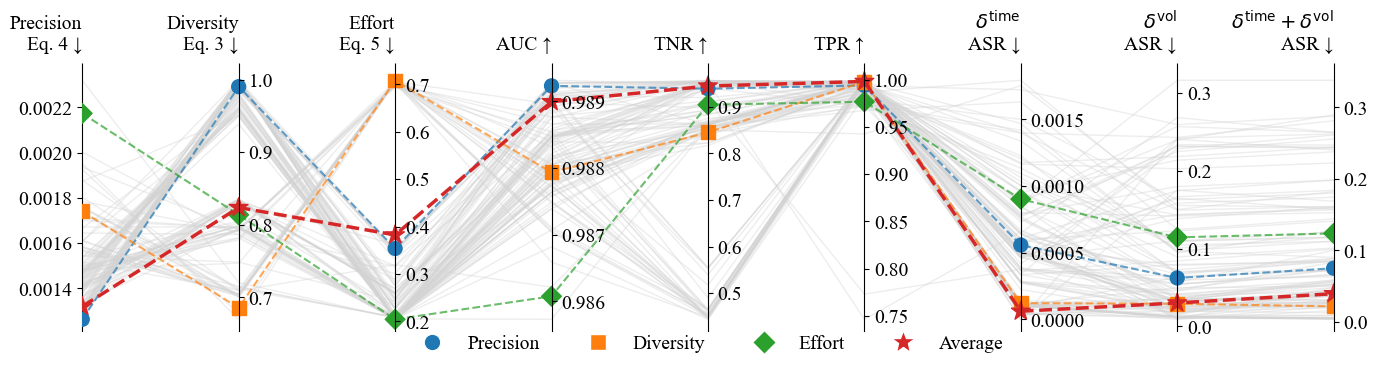

In [13]:
axis_names = ['Prec.', 'Div.', 'Eff.', 'AUC', 'Nrm. Acc.', 'Att. Acc.', 'T. ASR', 'V. ASR', 'T. V. ASR']
axis_names = ['Precision\nEq. 4', 'Diversity\nEq. 3', 'Effort\nEq. 5', 'AUC', 'TNR', 'TPR', r'$\delta^{\mathrm{time}}$'+'\nASR', r'$\delta^{\mathrm{vol}}$'+'\nASR', r'$\delta^{\mathrm{time}} + \delta^{\mathrm{vol}}$'+'\nASR']

df_overview_anyvote = df_overview.iloc[:, ga_inf+any] # Combine the GA and any voting method results
# Drop the 'generation' and 'individual' columns
overview_matrix = df_overview_anyvote.drop(columns=['generation', 'individual']).to_numpy()

# Compute the axis limits using the combined DataFram
limits = adjust_axis_limits(overview_matrix, 0.05)


# Plot in an individual figure
plot_parallel_coordinates_overview(
    df_overview_anyvote,
    use_curves=False,
    limits=limits,  # Use the computed limits
    objective_directions=objective_directions,  # Update this as per your requirement
    highlight=selected_solutions,  # Pass the selected solutions
    axis_names=axis_names,  # Pass the new axis names
    #title=f'Sorted by {name}',  # Pass the title
    figsize=(14, 4),  # Pass the figure size
    rotation=0,
    exclude_first_three_axes=False,
    save_to_pdf=f'best_parallel_coordinates.pdf',
    global_font_size=14,
    filled=True
)

## Performance of Selected Solutions on Clean Data (No Adversarial Evasion Attacks)

In [14]:
# AUC
results_voting_methods[100.0][45.0]['any']['df_attackwise_accuracy']

,category,total_instances,dt_accuracy,rf_accuracy,xgb_accuracy,mlp_accuracy,td_accuracy,ensemble_accuracy
0,normal,1687604,0.949446,0.957053,0.959844,0.956191,0.957539,0.948003
1,Worms,190,1.000000,1.000000,1.000000,1.000000,0.994737,1.000000
2,Shellcode,1428,0.998599,0.997899,0.964286,0.906863,0.996499,1.000000
3,Reconnaissance,11377,0.998769,0.999824,0.997451,0.993232,0.999385,1.000000
4,Generic,5452,0.985877,0.997799,0.992480,0.989545,0.985693,1.000000
5,Fuzzers,19000,0.992737,0.995474,0.931053,0.992895,0.986316,0.999947
6,Exploits,37697,0.994058,0.998833,0.984879,0.990211,0.992864,0.999973
7,DoS,4937,0.989062,0.996152,0.981770,0.960907,0.976909,1.000000
8,Backdoors,490,1.000000,0.997959,0.961224,0.997959,0.806122,1.000000
9,Analysis,725,1.000000,0.993103,0.755862,0.867586,0.995862,1.000000


In [15]:
# Average
results_voting_methods[100.0][5.0]['any']['df_attackwise_accuracy']

,category,total_instances,dt_accuracy,rf_accuracy,xgb_accuracy,mlp_accuracy,td_accuracy,ensemble_accuracy
0,normal,1687604,0.946089,0.958355,0.960397,0.958120,0.956535,0.944396
1,Worms,190,1.000000,0.989474,1.000000,0.984211,0.994737,1.000000
2,Shellcode,1428,1.000000,0.961485,0.975490,0.814426,1.000000,1.000000
3,Reconnaissance,11377,1.000000,0.997627,0.998682,0.991298,0.999736,1.000000
4,Generic,5452,1.000000,0.981291,0.991012,0.984043,0.990646,1.000000
5,Fuzzers,19000,0.999579,0.978368,0.946421,0.968105,0.990421,1.000000
6,Exploits,37697,0.999390,0.990742,0.986683,0.990583,0.989681,0.999920
7,DoS,4937,0.999797,0.984809,0.983998,0.953413,0.976909,1.000000
8,Backdoors,490,0.983673,0.936735,0.963265,0.985714,0.944898,1.000000
9,Analysis,725,0.994483,0.977931,0.772414,0.860690,0.863448,1.000000


In [16]:
# Precision
results_voting_methods[100.0][0.0]['any']['df_attackwise_accuracy']

,category,total_instances,dt_accuracy,rf_accuracy,xgb_accuracy,mlp_accuracy,td_accuracy,ensemble_accuracy
0,normal,1687604,0.938659,0.958750,0.959554,0.956349,0.984058,0.938613
1,Worms,190,1.000000,1.000000,1.000000,0.994737,0.794737,1.000000
2,Shellcode,1428,1.000000,0.950980,0.967787,0.974090,0.850140,1.000000
3,Reconnaissance,11377,0.999912,0.998506,0.998418,0.996133,0.888283,1.000000
4,Generic,5452,0.982392,0.992296,0.992480,0.993213,0.658841,1.000000
5,Fuzzers,19000,0.999316,0.971000,0.943526,0.986421,0.772684,1.000000
6,Exploits,37697,0.990954,0.995994,0.986577,0.996047,0.636258,0.999735
7,DoS,4937,0.989670,0.989872,0.985214,0.982986,0.582743,1.000000
8,Backdoors,490,0.991837,0.953061,0.961224,0.983673,0.571429,1.000000
9,Analysis,725,1.000000,0.932414,0.758621,0.968276,0.224828,1.000000


In [17]:
# Diversity
results_voting_methods[100.0][86.0]['any']['df_attackwise_accuracy']

,category,total_instances,dt_accuracy,rf_accuracy,xgb_accuracy,mlp_accuracy,td_accuracy,ensemble_accuracy
0,normal,1687604,0.862759,0.954038,0.959559,0.957222,0.950786,0.845002
1,Worms,190,0.963158,0.689474,0.994737,0.994737,0.936842,1.000000
2,Shellcode,1428,1.000000,0.450980,0.965686,0.957983,0.992997,1.000000
3,Reconnaissance,11377,1.000000,0.515250,0.998594,0.994990,0.998506,1.000000
4,Generic,5452,0.971203,0.510088,0.991012,0.985143,0.961849,1.000000
5,Fuzzers,19000,0.999842,0.611474,0.941158,0.989579,0.918684,1.000000
6,Exploits,37697,0.988859,0.574528,0.986445,0.991962,0.984906,0.999973
7,DoS,4937,0.988657,0.564310,0.983796,0.976707,0.978732,0.999797
8,Backdoors,490,1.000000,0.606122,0.981633,0.997959,0.946939,1.000000
9,Analysis,725,1.000000,0.535172,0.748966,0.931034,0.987586,1.000000


In [18]:
# Effort
results_voting_methods[100.0][93.0]['any']['df_attackwise_accuracy']

,category,total_instances,dt_accuracy,rf_accuracy,xgb_accuracy,mlp_accuracy,td_accuracy,ensemble_accuracy
0,normal,1687604,0.958355,0.911227,0.956700,0.956873,0.982678,0.904281
1,Worms,190,0.994737,0.705263,1.000000,1.000000,0.805263,1.000000
2,Shellcode,1428,0.967787,0.514006,0.976891,0.998599,0.703081,1.000000
3,Reconnaissance,11377,0.997978,0.612200,0.998330,0.998418,0.536433,1.000000
4,Generic,5452,0.981658,0.712032,0.996698,0.988995,0.644718,1.000000
5,Fuzzers,19000,0.971947,0.727105,0.928053,0.975211,0.767316,0.999211
6,Exploits,37697,0.993846,0.840783,0.999469,0.990185,0.641457,0.999973
7,DoS,4937,0.981770,0.822969,0.995746,0.969212,0.609885,0.999797
8,Backdoors,490,0.908163,0.869388,1.000000,0.985714,0.646939,1.000000
9,Analysis,725,0.899310,0.880000,0.995862,0.864828,0.445517,1.000000


## Robustness Evaluation Comparison: Baseline Models vs. Our Approach: Plotting the Solutions ASR

### BCA Models vs. Our Approach

Index: (100.0, 5.0)


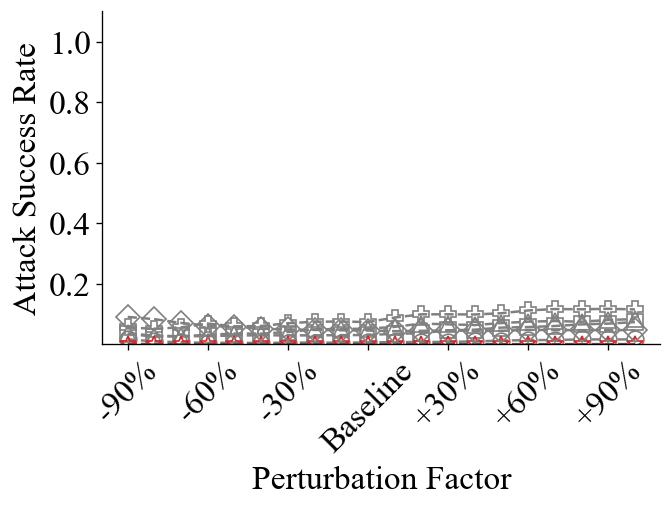

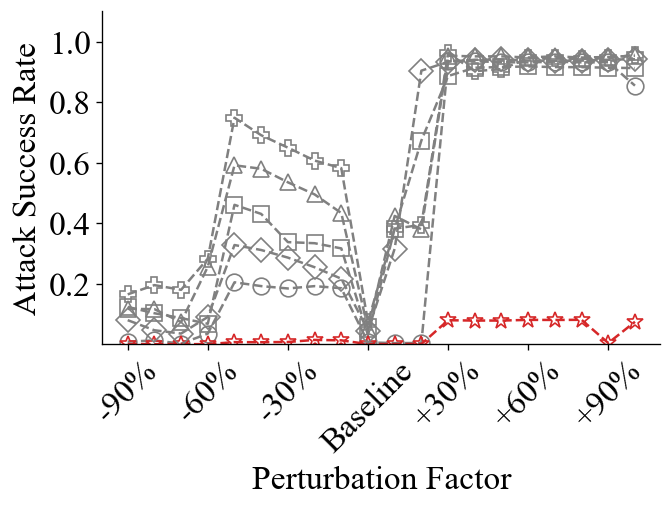

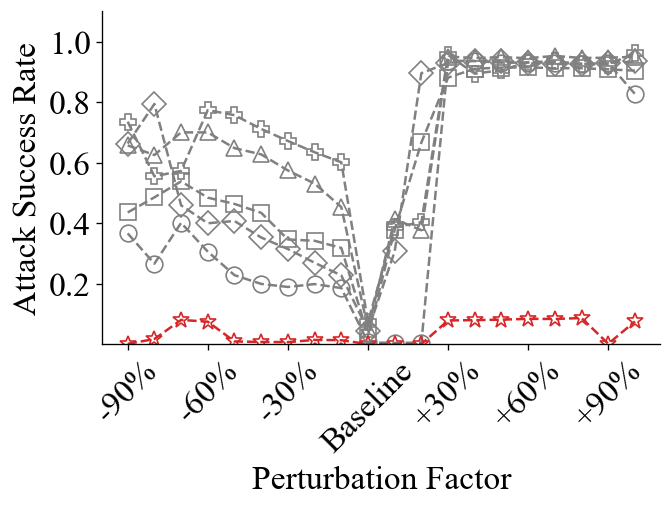

In [19]:
output_file_name = 'proposal_full_features'

# indexes = [(100.0, 45.0)]#, (100.0, 59.0), (100.0, 27.0)]
indexes = [(100.0, 5.0)]
bl_vs_proposal = {100.0: {}}

baseline_no_feature_selection = esp_utilities.load_from_pickle('../results/realistic/realistic_no_feature_selection_any.pkl')

# Dell BCA Ensemble
del baseline_no_feature_selection['ensemble']

for g, i in indexes:
    bl_vs_proposal[g][i] = update_dictionary_with_ensemble(
        ensemble_df=results_voting_methods[g][i]['any']['attack_evaluation_results_df'].loc[results_voting_methods[g][i]['any']['attack_evaluation_results_df']['model'] == 'ensemble'], 
        result_dict=baseline_no_feature_selection)

    bl_vs_proposal[g][i]['td'] = bl_vs_proposal[g][i]['tabular']
    del bl_vs_proposal[g][i]['tabular']
    

    print(f'Index: {g, i}')
    esp_utilities.plot_ensemble_asr(bl_vs_proposal[g][i], gray=True, output_filename=None)
    print('\n\n')

### BEA Models vs. Our Approach

Index: (100.0, 5.0)


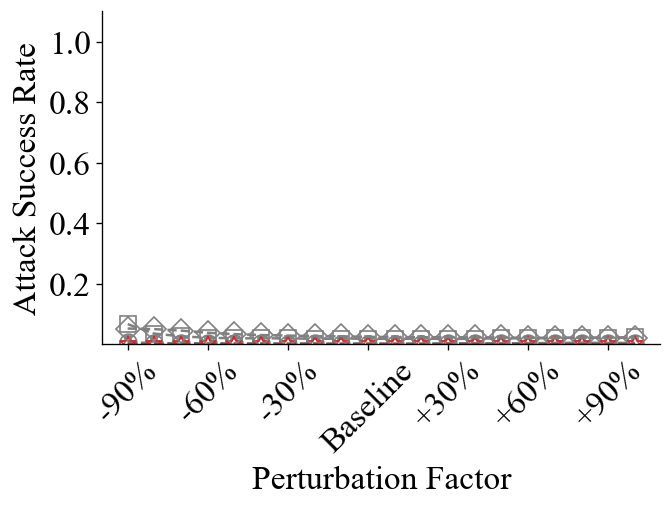

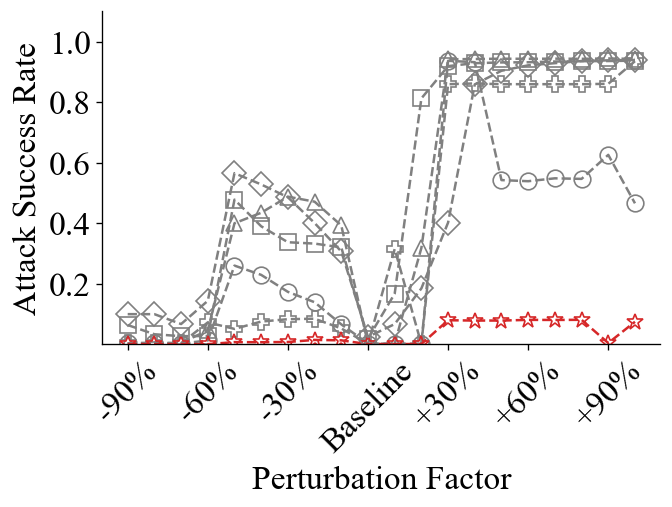

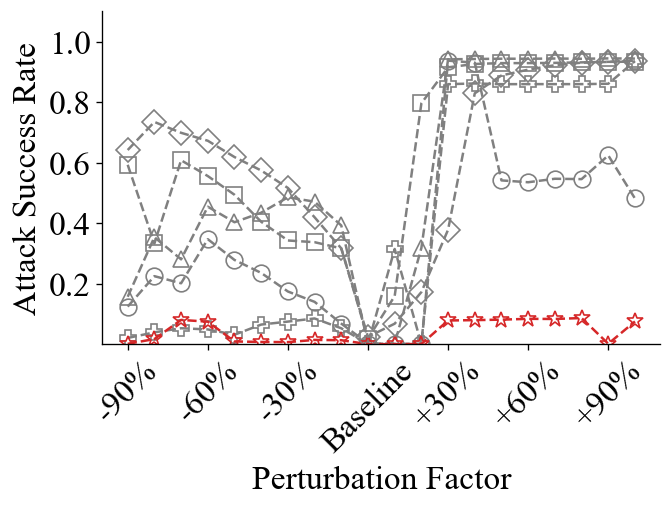

In [20]:
output_file_name = 'proposal_ga_features'
indexes = [(100.0, 5.0)] # Average Diversity
bl_vs_proposal = {100.0: {}}

baseline_ga_feature_selection = esp_utilities.load_from_pickle('../results/realistic/realistic_ga_feature_selection_any.pkl')

# dell BEA Ensemble
del baseline_ga_feature_selection['ensemble']

for g, i in indexes:
    bl_vs_proposal[g][i] = update_dictionary_with_ensemble(
        ensemble_df=results_voting_methods[g][i]['any']['attack_evaluation_results_df'].loc[results_voting_methods[g][i]['any']['attack_evaluation_results_df']['model'] == 'ensemble'], 
        result_dict=baseline_ga_feature_selection)

    bl_vs_proposal[g][i]['td'] = bl_vs_proposal[g][i]['tabular']
    del bl_vs_proposal[g][i]['tabular']
    

    print(f'Index: {g, i}')
    esp_utilities.plot_ensemble_asr(bl_vs_proposal[g][i], gray=True, output_filename=None)
    print('\n\n')

### BCA Ensemble and BEA Ensemble Models vs. Our Approach

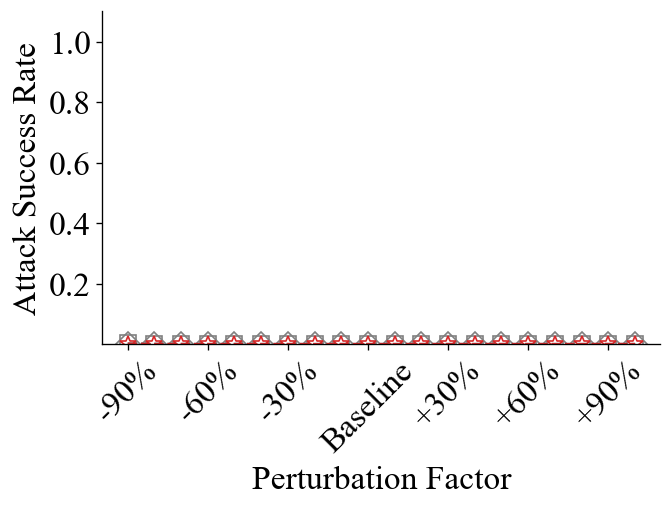

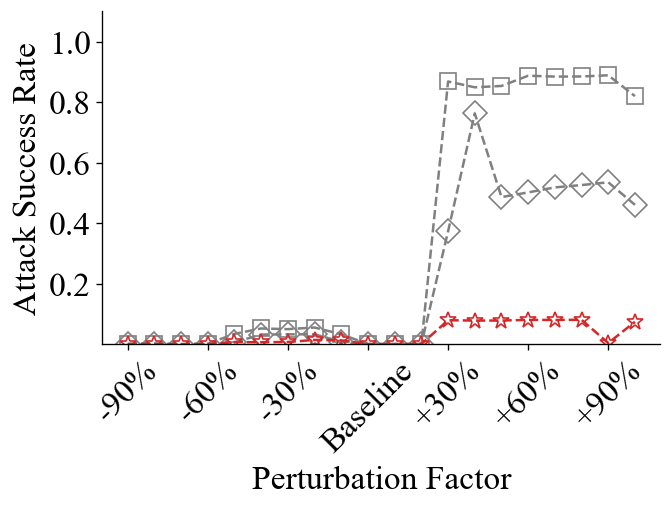

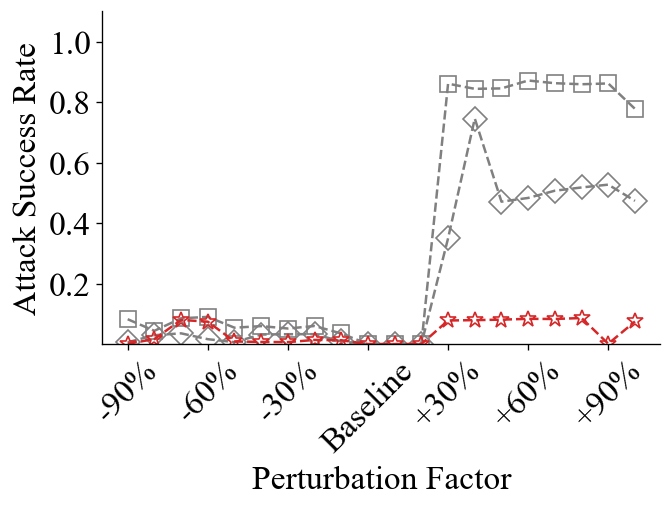

In [21]:
baselines = esp_utilities.load_from_pickle('../results/realistic/realistic_no_feature_selection_any.pkl')
baselines['td'] = baselines['tabular']
del baselines['tabular']

baselines_ga = esp_utilities.load_from_pickle('../results/realistic/realistic_ga_feature_selection_any.pkl')
baselines_ga['td'] = baselines_ga['tabular']
del baselines_ga['tabular']

output_file_name = 'ensemble_vs_ensemble'
# fig.patch.set_facecolor('#D8E8D8')
ensembles = {'bca_ensemble': baselines['ensemble'], 'bea_ensemble': baselines_ga['ensemble'], 'ensemble': bl_vs_proposal[100.0][5.0]['ensemble']}
# ensembles = {'bea_ensemble': baselines_ga['ensemble'], 'ensemble': bl_vs_proposal[100.0][45.0]['ensemble']}
esp_utilities.plot_ensemble_asr(ensembles, gray=True, output_filename=None, ensemble_only=True)

### Some ASR Statistics

In [22]:
# average ASR
values = ensembles['bca_ensemble']['time_volume'].values()

sum_ = sum(values)

average = sum_ / len(values)
average

0.36743714039896475

In [23]:
# average ASR
values = ensembles['bca_ensemble']['volume'].values()

sum_ = sum(values)

average = sum_ / len(values)
average

0.3582967440302727

In [24]:
values = ensembles['bea_ensemble']['time_volume'].values()

sum_ = sum(values)

average = sum_ / len(values)
average

0.21391583641502537

In [25]:
values = ensembles['bea_ensemble']['volume'].values()

sum_ = sum(values)

average = sum_ / len(values)
average

0.21388713655131736

In [26]:
# average ASR
values = ensembles['ensemble']['time_volume'].values()

sum_ = sum(values)

average = sum_ / len(values)
average

0.039513104233289784

In [27]:
# average ASR
values = ensembles['ensemble']['volume'].values()

sum_ = sum(values)

average = sum_ / len(values)
average

0.03001650909219611